<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v6: Unit activations
This notebook experiments with creating a utility to measure the rate of unit activations across layers and across the network.

The intended API is:
```python
stats = activation_utils.measure(model, dataset)
activation_utils.plot(stats)
```
Typically you would just pass the training dataset. And you might do this at semi-regular intervals during training to see how things vary across training.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit

In [2]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

class LessVerboseEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, display_interval=None, display_total=10):
        super(LessVerboseEpochLogger, self).__init__()
        self.display_interval = display_interval
        self.display_total = display_total

    def set_params(self, params):
        self.epoch_count = params['epochs']
        if self.display_interval == None:
          self.display_interval = math.floor(self.epoch_count / self.display_total)

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch + 1) % self.display_interval == 0) or epoch == self.epoch_count-1:
            print(f'Epoch {epoch + 1:5d}:', end=' ')
            for key, value in logs.items():
                print(f'{key}: {value:.4f}', end='  ')
            print()


## Simple test domain

In [3]:
def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


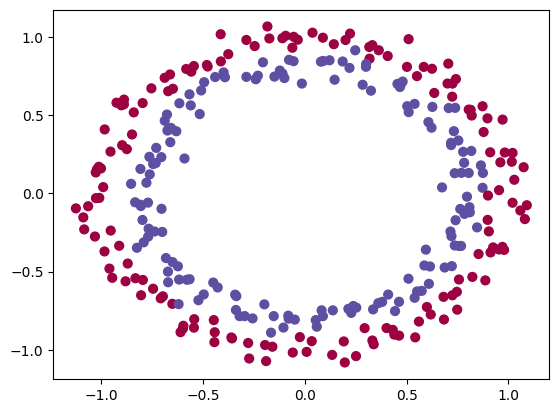

In [4]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [98]:
# tip: great results after 15,000 epochs, but it takes a long time to train
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=4500, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

# for later use
pre_trained_model = model

Epoch   450: loss: 0.6617  
Epoch   900: loss: 0.3785  
Epoch  1350: loss: 0.1242  
Epoch  1800: loss: 0.0676  
Epoch  2250: loss: 0.0410  
Epoch  2700: loss: 0.0271  
Epoch  3150: loss: 0.0209  
Epoch  3600: loss: 0.0171  
Epoch  4050: loss: 0.0145  
Epoch  4500: loss: 0.0126  
Total training time: 111.36 secs


In [5]:
# or alternatively, just take an untrained model
model = binary_classification_model('he_normal')
untrained_model = model

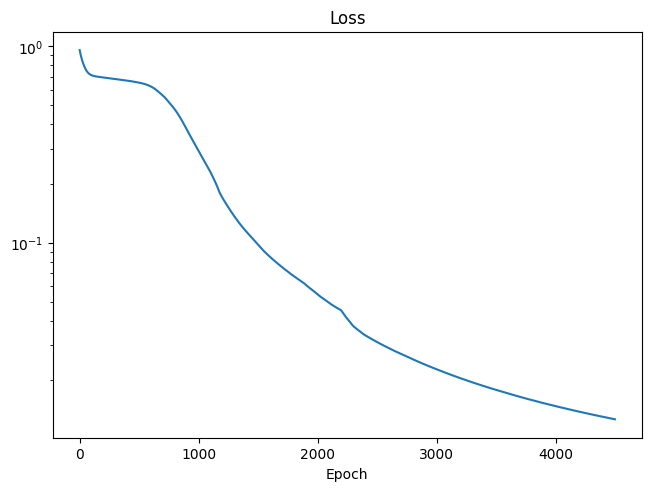

In [100]:
plot_fit(history)

## Experimental implementation

In [7]:
def measure_layer_activations(model, dataset):
  """
  Measures statistics against the number of active units (non-zero outputs)
  across each layer, by applying a dataset to the model and looking at the
  unit activations.

  Args:
  model: a tf.keras.Model - must have inputs defined
  dataset: a dataset to run against the model

  Return:
  dict{layer_name -> dict{ - stats for the given layer
    'min' -> double        - minimum number of active units for any sample
    'max' -> double        - maximum number of active units for any sample
    'mean' -> double       - mean number of active units across the dataset
    'stddev' -> double     - std.dev on number of active units
    'len' -> int           - total number of output units (irrespective of shape)
    ...percentiles...
  }}
  dict{'_model_rates_' -> dict{ - fractions of activations across entire model including output layer (not normalized by layer size)
    'min' -> double        - min fraction of active units for any sample
    'max' -> double        - max fraction of active units for any sample
    'mean' -> double       - mean fraction of active units across the dataset
    'stddev' -> double     - std.dev on fraction of active units
    ...percentiles...
  }}
  dict{'_norm_model_rates_' -> dict{ - fractions of activations across entire including output layer (normalized by layer size)
    'min' -> double        - min fraction of active units for any sample
    'max' -> double        - max fraction of active units for any sample
    'mean' -> double       - mean fraction of active units across the dataset
    'stddev' -> double     - std.dev on fraction of active units
    ...percentiles...
  }}
  dict{'_hidden_rates_' -> dict{ - fractions of activations across entire model except output layer (not normalized by layer size)
    'min' -> double        - min fraction of active units for any sample
    'max' -> double        - max fraction of active units for any sample
    'mean' -> double       - mean fraction of active units across the dataset
    'stddev' -> double     - std.dev on fraction of active units
    ...percentiles...
  }}
  dict{'_norm_hidden_rates_' -> dict{ - fractions of activations across entire model except output layer (normalized by layer size)
    'min' -> double        - min fraction of active units for any sample
    'max' -> double        - max fraction of active units for any sample
    'mean' -> double       - mean fraction of active units across the dataset
    'stddev' -> double     - std.dev on fraction of active units
    ...percentiles...
  }}

  Tips:
  - if taking a single model-wide set of stats, I'd pick the _norm_hidden_rates_.
  - if wanting a single scalar metric, I'd pick the mean of that set of stats.
  """

  def stats(data, tot, mode):
    div = 1.
    if mode == 'rate' or mode == 'mean':
      div = tot

    res = {
        'min': np.min(data) / div,
        'max': np.max(data) / div,
        'mean': np.mean(data) / div,
        'stddev': np.std(data) / div,
        '10th': np.percentile(data, 10) / div,
        '25th': np.percentile(data, 25) / div,
        'median': np.median(data) / div,
        '75th': np.percentile(data, 75) / div,
        '90th': np.percentile(data, 90) / div
    }
    if mode == 'value':
      res['len'] = tot
    return res


  # extract individual layer activations
  monitoring_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
  layer_outputs = monitoring_model(dataset)

  # collect per-layer results
  # -- N = batch size
  # -- L = number of layers
  res = {}
  active_counts = []  # L-len list of (N,)
  tots = []           # L-len list of (1,)
  for layer, output in zip(model.layers, layer_outputs):
    tot = np.prod(output.shape[1:]) # omit batch size
    active = np.count_nonzero(output.numpy(), axis=tuple(range(1, output.ndim)))  # keep just the first dim
    res[layer.name] = stats(active, tot, 'value')
    active_counts.append(active)
    tots.append(tot)

  # collect aggregate rates
  # - units are given equal weight, regardless of whether their layer has many units or few,
  #   thus layers with more units have a greater share in the result,
  #   and thus we're looking at the fraction of units ACROSS THE ENTIRE MODEL.
  active_counts = np.stack(active_counts, axis=1)  # convert to (N,L) array
  res['_model_rates_'] = stats(np.sum(active_counts, axis=1), np.sum(tots), 'rate')
  res['_hidden_rates_'] = stats(np.sum(active_counts[:,:-1], axis=1), np.sum(tots[:-1]), 'rate')

  # collect aggregate per-layer normalized rates
  # - we give each layer the same weight, regardless of how many units,
  #   thus we're looking at the fraction of units PER LAYER.
  res['_norm_model_rates_'] = stats(np.sum(active_counts / tots, axis=1), len(tots), 'mean')
  res['_norm_hidden_rates_'] = stats(np.sum(active_counts[:,:-1] / tots[:-1], axis=1), len(tots[:-1]), 'mean')

  return res

#r = measure_layer_activations(pre_trained_model, train_X)

In [103]:
r = measure_layer_activations(pre_trained_model, train_X)
r

{'dense_6': {'min': 3.0,
  'max': 8.0,
  'mean': 5.743333333333333,
  'stddev': 1.5462176072237985,
  '10th': 3.0,
  '25th': 5.0,
  'median': 6.0,
  '75th': 7.0,
  '90th': 8.0,
  'len': 10},
 'dense_7': {'min': 2.0,
  'max': 5.0,
  'mean': 4.476666666666667,
  'stddev': 0.6996110030263644,
  '10th': 4.0,
  '25th': 4.0,
  'median': 5.0,
  '75th': 5.0,
  '90th': 5.0,
  'len': 5},
 'dense_8': {'min': 1.0,
  'max': 1.0,
  'mean': 1.0,
  'stddev': 0.0,
  '10th': 1.0,
  '25th': 1.0,
  'median': 1.0,
  '75th': 1.0,
  '90th': 1.0,
  'len': 1},
 '_model_rates_': {'min': 0.375,
  'max': 0.875,
  'mean': 0.70125,
  'stddev': 0.11487538538201589,
  '10th': 0.5,
  '25th': 0.625,
  'median': 0.6875,
  '75th': 0.8125,
  '90th': 0.8125},
 '_hidden_rates_': {'min': 0.3333333333333333,
  'max': 0.8666666666666667,
  'mean': 0.6813333333333333,
  'stddev': 0.12253374440748362,
  '10th': 0.4666666666666667,
  '25th': 0.6,
  'median': 0.6666666666666666,
  '75th': 0.8,
  '90th': 0.8},
 '_norm_model_rates_'

In [8]:
r = measure_layer_activations(untrained_model, train_X)
r

{'dense': {'min': 2.0,
  'max': 8.0,
  'mean': 4.993333333333333,
  'stddev': 1.30637751902818,
  '10th': 4.0,
  '25th': 4.0,
  'median': 5.0,
  '75th': 6.0,
  '90th': 6.0,
  'len': 10},
 'dense_1': {'min': 1.0,
  'max': 4.0,
  'mean': 2.2266666666666666,
  'stddev': 0.9355687515564469,
  '10th': 1.0,
  '25th': 1.0,
  'median': 3.0,
  '75th': 3.0,
  '90th': 3.0,
  'len': 5},
 'dense_2': {'min': 1.0,
  'max': 1.0,
  'mean': 1.0,
  'stddev': 0.0,
  '10th': 1.0,
  '25th': 1.0,
  'median': 1.0,
  '75th': 1.0,
  '90th': 1.0,
  'len': 1},
 '_model_rates_': {'min': 0.25,
  'max': 0.8125,
  'mean': 0.51375,
  'stddev': 0.12621699238480794,
  '10th': 0.375,
  '25th': 0.375,
  'median': 0.5625,
  '75th': 0.625,
  '90th': 0.625},
 '_hidden_rates_': {'min': 0.2,
  'max': 0.8,
  'mean': 0.48133333333333334,
  'stddev': 0.13463145854379516,
  '10th': 0.3333333333333333,
  '25th': 0.3333333333333333,
  'median': 0.5333333333333333,
  '75th': 0.6,
  '90th': 0.6},
 '_norm_model_rates_': {'min': 0.46666

In [111]:
def measure_unit_activations(model, dataset):
  """
  Measures statistics of the activation rates of each unit (percentage of occurrences that the unit has non-zero output)
  by applying a dataset to the model and looking at the unit activations.

  Args:
  model: a tf.keras.Model - must have inputs defined
  dataset: a dataset to run against the model

  Return:
  dict{layer_name -> np.array} - array in same shape as the output of the layer (except batch dimension),
          with each unit containing its fraction of samples that it is active for
  """

  # extract individual layer activations
  monitoring_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
  layer_outputs = monitoring_model(dataset)

  # collect per-layer results
  # -- N = batch size
  # -- L = number of layers
  res = {}
  active_counts = []  # L-len list of (N,)
  tots = []           # L-len list of (1,)
  n = dataset.shape[0]
  for layer, output in zip(model.layers, layer_outputs):
    active = np.count_nonzero(output.numpy(), axis=0)
    res[layer.name] = active / n

  return res

r = measure_unit_activations(pre_trained_model, train_X)

In [113]:
r = measure_unit_activations(pre_trained_model, train_X)
r

{'dense_6': array([0.37666667, 0.50333333, 0.45333333, 1.        , 0.51333333,
        0.51666667, 0.42666667, 0.45666667, 1.        , 0.49666667]),
 'dense_7': array([0.94333333, 0.84333333, 0.91      , 0.95666667, 0.82333333]),
 'dense_8': array([1.])}

In [114]:
r = measure_unit_activations(untrained_model, train_X)
r

{'dense_9': array([0.50333333, 0.5       , 0.50666667, 0.50666667, 0.51      ,
        0.49666667, 0.49333333, 0.50333333, 0.5       , 0.49666667]),
 'dense_10': array([1.        , 0.46333333, 0.65333333, 0.72333333, 0.47666667]),
 'dense_11': array([1.])}

In [110]:
r[0]

{'dense_6': array([0.37666667, 0.50333333, 0.45333333, 1.        , 0.51333333,
        0.51666667, 0.42666667, 0.45666667, 1.        , 0.49666667]),
 'dense_7': array([0.94333333, 0.84333333, 0.91      , 0.95666667, 0.82333333]),
 'dense_8': array([1.])}

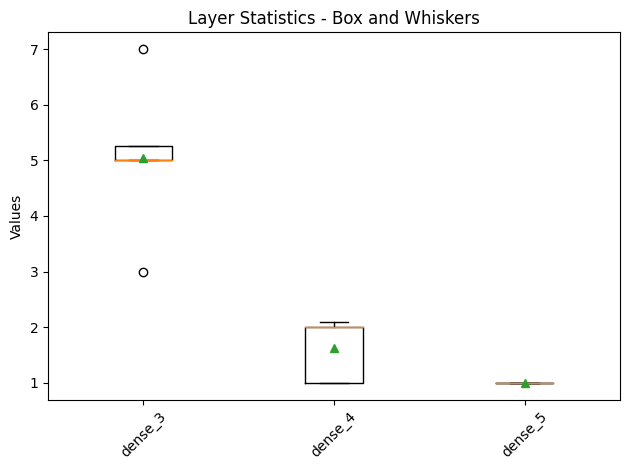

In [99]:
def plot_layer_stats(stats_dict):
    # Prepare data for the box plot
    boxplot_data = []
    labels = []

    for layer, stats in stats_dict.items():
        # Create a list of percentiles for each layer
        percentiles = [
            stats['10th'],
            stats['25th'],
            stats['median'],
            stats['75th'],
            stats['90th']
        ]
        boxplot_data.append(percentiles)
        labels.append(layer)

    # Create the box plot
    fig, ax = plt.subplots()
    ax.boxplot(boxplot_data, labels=labels, showmeans=True)

    # Customize the plot
    ax.set_title('Layer Statistics - Box and Whiskers')
    ax.set_ylabel('Values')

    # Display the plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
layer_stats = {
    'dense_3': {'min': 2.0, 'max': 8.0, 'mean': 4.986666666666666, 'stddev': 1.5099080178018203, '10th': 3.0, '25th': 5.0, 'median': 5.0, '75th': 5.25, '90th': 7.0, 'len': 10},
    'dense_4': {'min': 1.0, 'max': 3.0, 'mean': 1.7233333333333334, 'stddev': 0.6325521498044427, '10th': 1.0, '25th': 1.0, 'median': 2.0, '75th': 2.0, '90th': 2.1, 'len': 5},
    'dense_5': {'min': 1.0, 'max': 1.0, 'mean': 1.0, 'stddev': 0.0, '10th': 1.0, '25th': 1.0, 'median': 1.0, '75th': 1.0, '90th': 1.0, 'len': 1}
}

plot_layer_stats(layer_stats)

## Monitoring Activity Rates during Training
Can we collect activity data during training?
For example, maybe we'll collect the set of `_norm_hidden_rates_` stats at the end of each epoch and then plot that against the loss curve and we might see some interesting correlations.

In [43]:
# Attempting via a callback
class ActivityRateCallback(tf.keras.callbacks.Callback):
  def __init__(self, dataset, **kwargs):
    """
    Args:
    dataset - dataset to use to measure activity rates at end of each epoch

    Keyward Args:
    series - String or list specifying which sets of stats to return from measure_layer_activations().
      Where multiple sets are returned, the returned keys are prefixed with the set name.
      That is omitted if there is only one set being returned.
      None = all sets.
      Default: '_norm_hidden_rates_'.

    interval - Will capture results every 'interval' epochs.
      Default: 1
    """
    super(ActivityRateCallback, self).__init__()
    self._dataset = dataset
    self._history = {}
    self._series = kwargs.get('series', '_norm_hidden_rates_')
    self._interval = kwargs.get('interval', 1)

  def on_epoch_end(self, epoch, logs=None):
    if epoch % self._interval == 0:
      self._collect_stats(epoch)

  def _collect_stats(self, epoch):
    activity_stats = measure_layer_activations(self.model, self._dataset)
    self._history.setdefault('epoch', []).append(epoch)

    series = self._series
    if series is None:
      series = list(activity_stats.keys())
    elif isinstance(series, str):
      series = [series]

    for serie in series:
      for key, value in activity_stats[serie].items():
        prefix = '' if len(series) == 1 else serie + '_'
        self._history.setdefault(prefix+key, []).append(value)

  @property
  def history(self):
    """
    Returns the history collected during training.
    Returns:
      dict{str -> list} - keyed by the statistic, eg: 'mean', and possibly prefixed by the series name.
    """
    return self._history


start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
activityRates = ActivityRateCallback(dataset=train_X, series=None, interval=10)
history = model.fit(train_X, train_Y, epochs=15000, batch_size=train_X.shape[0], verbose=0, callbacks=[activityRates, LessVerboseEpochLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch  1500: loss: 0.6930  
Epoch  3000: loss: 0.1231  
Epoch  4500: loss: 0.0257  
Epoch  6000: loss: 0.0126  
Epoch  7500: loss: 0.0087  
Epoch  9000: loss: 0.0071  
Epoch 10500: loss: 0.0065  
Epoch 12000: loss: 0.0062  
Epoch 13500: loss: 0.0062  
Epoch 15000: loss: 0.0061  
Total training time: 429.32 secs


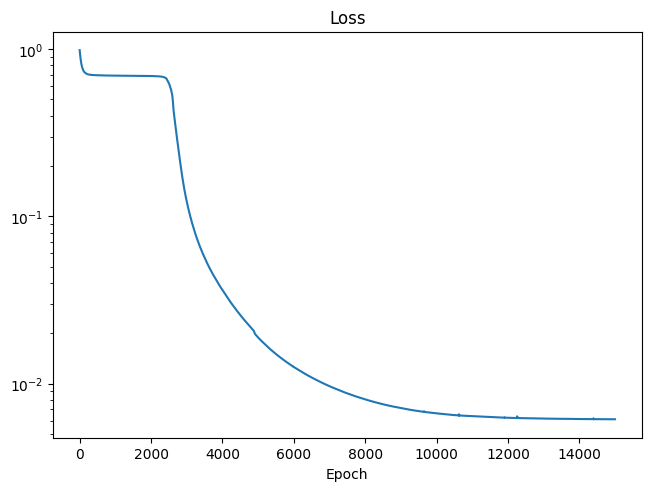

In [45]:
plot_fit(history)

Text(0, 0.5, 'Fraction of active units')

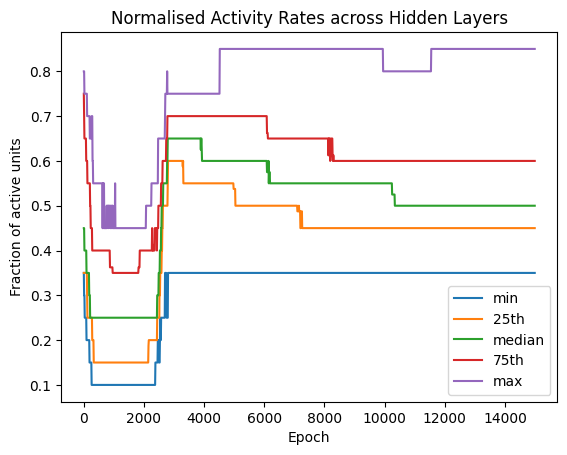

In [44]:
plt.figure()
for key in ['min', '25th', 'median', '75th', 'max']:
  plt.plot(activityRates.history['epoch'], activityRates.history['_norm_hidden_rates__' + key], label=key)
plt.legend()
plt.title('Normalised Activity Rates across Hidden Layers')
plt.xlabel('Epoch')
plt.ylabel('Fraction of active units')

Text(0, 0.5, 'Fraction of active units')

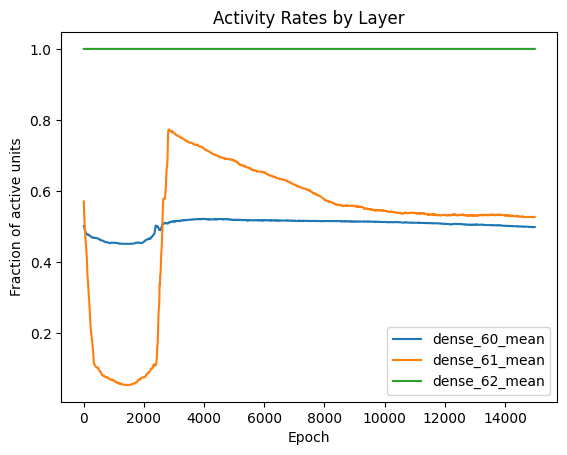

In [46]:
plt.figure()
for key, value in activityRates.history.items():
  if not key.startswith('_') and key.endswith('_mean'):
    len_key = key.replace('_mean', '_len')
    rate = np.array(activityRates.history[key]) / np.array(activityRates.history[len_key])
    plt.plot(activityRates.history['epoch'], rate, label=key)
plt.legend()
plt.title('Activity Rates by Layer')
plt.xlabel('Epoch')
plt.ylabel('Fraction of active units')